# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [223]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mesa
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [224]:
class Household(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        probabilities = np.array([0.66, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.01, 0.07, 0.01, 0.01, 0.01, 0.07])
        probabilities /= probabilities.sum()
        self.random_param = ""

        self.amount_of_solarpanels = np.random.choice(values, p=probabilities)
        self.consume_ph = np.random.randint(399, 513 + 1)
        self.produce_ph = self.amount_of_solarpanels * np.random.randint(300, 340 + 1)
        self.energy = 456
        self.money = 10
        self.price_per_Wh = 0.00024

    def trade_energy(self):
        self.energy += self.produce_ph
        self.energy -= self.consume_ph
        print(self.random_param)

        while True:
            possible_buyers = [agent for agent in self.model.agents if agent.energy < agent.consume_ph]
            surplus_energy = self.energy - self.consume_ph

            if surplus_energy > 0 and not possible_buyers:
                sell_to_gov = surplus_energy * self.price_per_Wh
                self.money += sell_to_gov
                self.energy -= surplus_energy
                break  

            if surplus_energy <= 0 or not possible_buyers:
                break

            possible_buyers.sort(key=lambda agent: agent.consume_ph - agent.energy, reverse=True)

            for other_household in possible_buyers:
                trade_amount = min(surplus_energy, other_household.consume_ph - other_household.energy)

                if trade_amount <= 0:
                    continue

                self.energy -= trade_amount
                other_household.energy += trade_amount
                surplus_energy -= trade_amount

                amount_owed = self.price_per_Wh * trade_amount

                if other_household.money >= amount_owed:
                    self.money += amount_owed
                    other_household.money -= amount_owed
                else:
                    affordable_trade = other_household.money / self.price_per_Wh
                    self.money += other_household.money
                    other_household.money = 0
                    trade_amount = affordable_trade
                    self.energy += (trade_amount - affordable_trade)

                if surplus_energy <= 0:
                    break

In [225]:
class Household_2(mesa.Agent):
    """
    Agent representing a household with energy consumption, production, and trading behavior.
    """

    def __init__(self, model):
        """
        Initializes a household agent with a random number of solar panels and corresponding production/consumption.
        """
        super().__init__(model)

        values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        probabilities = np.array([0.58, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.01, 0.07, 0.01, 0.01, 0.01, 0.12])
        probabilities /= probabilities.sum()
        self.amount_of_solarpanels = np.random.choice(values, p=probabilities)

        self.consumption_data = np.random.randint(399, 514)
        self.production_data = self.amount_of_solarpanels * np.random.randint(300, 341)

        self.energy_usage = {
            'night': {'hours': range(0, 6), 'percentage': 0.05},
            'morning': {'hours': range(6, 12), 'percentage': 0.25},
            'afternoon': {'hours': range(12, 18), 'percentage': 0.30},
            'evening': {'hours': range(18, 24), 'percentage': 0.40},
        }

        self.supply = 1
        self.demand = 1

        self.remaining_energy = 0
        self.consumed = 0
        self.produced = 0
        self.trade_amount = 0

        self.energy_price = self.model.energy_price
        self.grid_price = 0.1710

        # print(f"[INIT] Household initialized with {self.amount_of_solarpanels} solar panels.")
        # print(f"[INIT] Consumption: {self.consumption_data} | Production: {self.production_data}")

    def trade_energy(self):
        # print(f"\n[TRADE] Time: Day {self.model.day_str}, Hour {self.model.hour}")
        self._calculate_energy()
        self._trading()

        if self.remaining_energy > 0:
            self.model.daily_supply += self.remaining_energy
        else:
            self.model.daily_demand += abs(self.remaining_energy)

    def _calculate_energy(self):
        self.consumed = self.consumption_data
        self.produced = self.production_data
        self.remaining_energy = self.produced - self.consumed
        # print(f"[CALC] Consumed: {self.consumed}, Produced: {self.produced}, Remaining: {self.remaining_energy}")

    def _trading(self):
        self._look_for_trades()
        if not self.buyers:
            # print("[TRADE] No buyers found.")
            return

        if self.remaining_energy <= 0:
            # print("[TRADE] No surplus energy to trade.")
            return

        self._exchange_energy(self.buyers)

    def _look_for_trades(self):
        self.buyers = [
            agent for agent in self.model.agents
            if agent.remaining_energy < agent.consumed
        ]
        self.sellers = [
            agent for agent in self.model.agents
            if agent.remaining_energy > agent.consumed
        ]
        # print(f"[MARKET] Buyers: {len(self.buyers)} | Sellers: {len(self.sellers)}")

    def _exchange_energy(self, buyers):
        for buyer in buyers:
            potential_trade = buyer.consumed - buyer.remaining_energy
            if potential_trade <= 0:
                continue

            trade_amount = min(self.remaining_energy, potential_trade)

            if trade_amount <= 0:
                continue

            self.remaining_energy -= trade_amount
            buyer.remaining_energy += trade_amount

            # print(f"[EXCHANGE] Traded {trade_amount} units to Buyer (ID: {buyer.unique_id})")
            # print(f"[TRADER] Remaining energy: {self.remaining_energy}W")

            if self.remaining_energy <= 0:
                # print("[TRADE] No more energy to trade.")
                break

    def _change_price(self):
        self.demand = len(self.buyers)
        if len(self.sellers) != 0:
            self.supply = len(self.sellers)
        else:
            return None
        new_price = self.energy_price * (self.demand / self.supply)
        new_price = max(0.10, min(new_price, self.grid_price))
        # print(f"[PRICE] Old Price: {self.energy_price:.4f}, New Price: {new_price:.4f}")
        self.energy_price = new_price

In [231]:
class NewGrid(mesa.Model):
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        self.datetime = datetime(2024, 1, 1)
        self.hour = 0
        self.day_str = self.datetime.strftime("%d-%m-%Y")

        self.daily_demand = 1
        self.daily_supply = 1
        self.energy_price = 0.16
        self.grid_price = 0.171

        Household_2.create_agents(model=self, n=n)

    def _time_skip(self):
        if self.hour != 23:
            self.hour += 1
        else:
            self.datetime += relativedelta(days=1)
            self.day_str = self.datetime.strftime("%d-%m-%Y")
            self.hour = 0
        
        if self.hour == 0:
            self._update_energy_price()

        # print(f"[TIME] Time advanced to Day {self.day_str}, Hour {self.hour}")

    def _update_energy_price(self):
        if self.daily_supply == 0:
            price = self.grid_price  # fallback if no supply
        else:
            ratio = self.daily_demand / self.daily_supply
            price = self.energy_price * ratio
            price = max(0.10, min(price, self.grid_price))

        print(f"[DAILY PRICE UPDATE] {self.day_str}: Demand={self.daily_demand}, Supply={self.daily_supply}, New Price={price:.4f}")
        self.energy_price = price

        # Reset for next day
        self.daily_demand = 0
        self.daily_supply = 0

    def step(self):
        self.agents.shuffle_do("trade_energy")
        for agent in self.agents:
            print(f"""
            Statistics for Agent {agent}:
            Current day: {self.day_str}
            Current energy price: {agent.energy_price}
            Current remaining energy: {agent.remaining_energy}
            Last consumed: {agent.consumed}
            Last produced: {agent.produced}
            Total agent amount: {self.num_agents}
            """)
    
    def long_step(self, n):
        for _ in range(0, n):
            self.agents.shuffle_do("trade_energy")

            self._time_skip()

            for agent in self.agents:
                print(f"[PRICE UPDATE {self.day_str}] The energy price changed to {agent.energy_price}")
                break

In [233]:
sim = NewGrid(20)
sim.step()


            Statistics for Agent <__main__.Household_2 object at 0x000001851AFC0D10>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: -403
            Last consumed: 403
            Last produced: 0
            Total agent amount: 20
            

            Statistics for Agent <__main__.Household_2 object at 0x000001851AD864B0>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: 2701
            Last consumed: 459
            Last produced: 3160
            Total agent amount: 20
            

            Statistics for Agent <__main__.Household_2 object at 0x000001851AD854F0>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: 500
            Last consumed: 500
            Last produced: 0
            Total agent amount: 20
            

            Statistics for Agent <__main__.Household_2 obj

In [234]:
sim.long_step(7*24)

[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.16
[PRICE UPDATE 01-01-2024] The energy price changed to 0.

In [8]:
class Microgrid(mesa.Model):
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.parameters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

        Household.create_agents(model=self, n=n)

    def step(self):
        self.agents.shuffle_do("trade_energy")

    def day_sim(self):
        for i in range(1, 25):
            for agent in self.agents:
                agent.random_param = self.parameters[i-1]
            self.agents.shuffle_do("trade_energy")

In [9]:
sim = Microgrid(20)
sim.step()

In [10]:
sim = Microgrid(20)
for _ in range(24):
    sim.step()

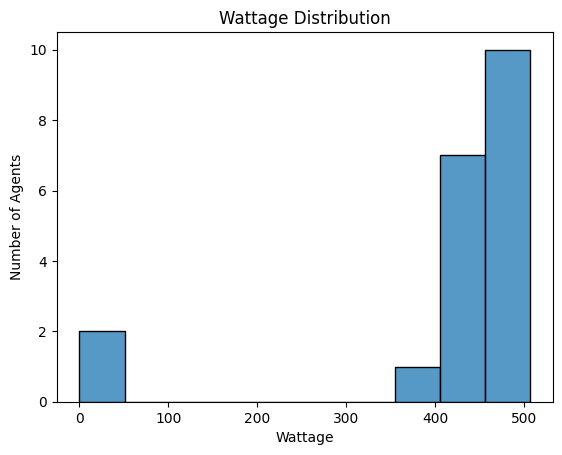

In [11]:
agent_wealth = [
    a.energy for a in sim.agents
]

g = sns.histplot(
    agent_wealth
)

g.set(
    title="Wattage Distribution", xlabel="Wattage", ylabel="Number of Agents"
);